# **Load Packages**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# **Load Data**
* 数据参照原始论文提供的预处理代码，已使用stata进行清洗
* treatment: guest_black
* outcome: yes
* control:

In [3]:
data = pd.read_csv('processed_data.csv')

In [4]:
# 返回data[["yes","host_response"]]中yes是nan的行
data[data["yes"].isnull()][["yes","host_response"]]["host_response"].value_counts()

Message not sent             125
Offers a different place      26
Confused (our date error)      4
Name: host_response, dtype: int64

In [5]:
data = data.dropna(subset=["yes"])
data.reset_index(drop=True, inplace=True)
data

,host_response,response_date,number_of_messages,automated_coding,latitude,longitude,bed_type,property_type,cancellation_policy,number_guests,...,los_angeles,sl,dc,total_guests,raw_black,prop_black,any_black,past_guest_merge,filled_september,pr_filled
0,Yes,2015-07-19 08:26:17,2.0,1.0,34.0815,-118.2700,Real Bed,House,Flexible,3.0,...,1,0,0,11.0,0.0,0.000000,0.0,matched (3),1,0.412335
1,No or unavailable,2015-07-14 14:13:39,NaN,1.0,38.9107,-77.0198,NaN,House,Moderate,2.0,...,0,0,1,167.0,0.0,0.000000,0.0,matched (3),1,0.686212
2,Request for more info (Can you verify? How man...,2015-07-20 16:24:08,2.0,0.0,34.0047,-118.4810,Pull-out Sofa,Apartment,Strict,1.0,...,1,0,0,19.0,0.0,0.000000,0.0,matched (3),0,0.330621
3,I will get back to you,2015-07-20 06:47:38,NaN,0.0,34.0917,-118.2820,NaN,House,Strict,8.0,...,1,0,0,41.0,0.0,0.000000,0.0,matched (3),0,0.535649
4,"Yes, if you verify/give more info",2015-07-18 18:07:19,NaN,0.0,34.0809,-118.3670,NaN,Apartment,Strict,3.0,...,1,0,0,263.0,1.0,0.003802,1.0,matched (3),1,0.855355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6230,Yes,2015-07-17 04:14:30,2.0,0.0,34.1737,-118.3440,Real Bed,House,Flexible,2.0,...,1,0,0,19.0,0.0,0.000000,0.0,matched (3),1,0.366860
6231,Check back later for definitive answer,2015-07-21 00:48:13,NaN,0.0,34.0428,-118.5620,NaN,House,Strict,9.0,...,1,0,0,NaN,0.0,0.000000,0.0,master only (1),0,0.292540
6232,Request for more info (Can you verify? How man...,2015-07-20 21:52:09,2.0,0.0,33.8766,-118.4020,NaN,Apartment,Flexible,6.0,...,1,0,0,6.0,0.0,0.000000,0.0,matched (3),0,0.396052
6233,Yes,2015-07-17 19:03:08,6.0,0.0,33.8679,-117.9230,NaN,House,Strict,4.0,...,1,0,0,10.0,1.0,0.100000,1.0,matched (3),1,0.323459


# **Problem 2**
> Let’s first focus on learning the average treatment effect of the treatment on the outcome of
your choice. 


---------------
## **(a)**
* Describe `conditions/assumptions` under which the average treatment effect can be identified from the observed data,      
* and discuss whether the conditions/assumptions are `plausible` for the data you chose.
---------------

---------------
## **(b)**
* Apply the simple `difference-in-mean` estimator and `linear regressions` to estimate the average treatment effect.     
* Report the `confidence interval` and `hypothesis testing results` for the
average treatment effect.      
* Are these valid ways to estimate the average treatment effect? Why?
---------------

In [5]:
group_treat = data[data['guest_black']==1]["yes"].reset_index(drop=True)
group_control = data[data['guest_black']==0]["yes"].reset_index(drop=True)

In [6]:
treat_mean = group_treat.mean()
control_mean = group_control.mean()
diff_in_mean = treat_mean - control_mean
print("simple difference in mean: ", diff_in_mean)

simple difference in mean:  -0.07961289815350497


In [7]:
"""
def sem(data):
    n = len(data)
    s = np.std(data, ddof=1)  # ddof=1 表示使用样本标准差
    return s / np.sqrt(n)
"""

se_1 = stats.sem(group_treat)
se_0 = stats.sem(group_control)
se_diff = np.sqrt(se_1**2 + se_0**2)
confidence_level = 0.95
z = stats.norm.ppf(1-(1-confidence_level)/2) # Normal distribution临界值
ci_lower = diff_in_mean - z*se_diff
ci_upper = diff_in_mean + z*se_diff

# 计算p值
t_stat, p_value = stats.ttest_ind(group_treat, group_control, equal_var=False)
print("simple difference in mean: ", diff_in_mean)
print(f"95% CI: [{ci_lower}, {ci_upper}]")
print(f"p-value: {p_value}")

simple difference in mean:  -0.07961289815350497
95% CI: [-0.1042237777433738, -0.05500201856363615]
p-value: 2.4551121238500043e-10


In [8]:
# linear regression
import statsmodels.api as sm
X = data[["guest_black"]]
X = sm.add_constant(X)
y = data["yes"]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    yes   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     40.18
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           2.47e-10
Time:                        21:17:42   Log-Likelihood:                -4471.9
No. Observations:                6235   AIC:                             8948.
Df Residuals:                    6233   BIC:                             8961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4878      0.009     55.242      

In [9]:
# data各列的type
type_list=data.dtypes
lst = type_list[type_list!="object"].index
lst = lst.difference(['super_host', 'number_of_messages', 'apt_rating', 'cleaning_fee', 'september_price', 'up_not_available_september', 'available_september'])
lst = lst.difference(["yes"])
lst = lst.difference(["guest_male", "guest_white","guest_race_continuous"]) #共线
print(len(lst))

# data用每列众数填充空值
data = data.fillna(data.mode().iloc[0])

65


In [10]:
# linear regression
import statsmodels.api as sm
X = data[lst].copy()
# X中心化zscore
X = (X - X.mean())  # centering 
X["guest_black"] = data["guest_black"]
X = sm.add_constant(X)
y = data["yes"]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    yes   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     12.56
Date:                Wed, 08 Jan 2025   Prob (F-statistic):          1.53e-119
Time:                        21:17:42   Log-Likelihood:                -4110.2
No. Observations:                6235   AIC:                             8350.
Df Residuals:                    6170   BIC:                             8788.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [11]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.4845,0.019,25.635,0.000,0.447,0.522
any_black,-0.0071,0.026,-0.272,0.786,-0.058,0.044
asian_proportion,0.4425,0.587,0.753,0.451,-0.709,1.594
asians,-6.338e-05,0.000,-0.469,0.639,-0.000,0.000
automated_coding,-0.0830,0.012,-6.781,0.000,-0.107,-0.059
baltimore,0.0629,2.316,0.027,0.978,-4.478,4.604
bathrooms,0.2629,0.142,1.847,0.065,-0.016,0.542
bedrooms,-0.0093,0.039,-0.242,0.809,-0.085,0.066
black_proportion,0.3128,0.567,0.552,0.581,-0.798,1.424
blacks,-2.351e-05,0.000,-0.181,0.857,-0.000,0.000


--------------------------------------------
## **(c)**
* Apply a `Double/Debiased Machine Learning (DML) method` (such as the partially linear
model or the double robust method) to estimate the average treatment effect. 
* Use at least `three` machine learning methods (e.g., Lasso, ridge, random forests, boosting, neural
nets) to estimate unknown nuisance functions in this process.
* `Compare` their results and discuss `why` DML may be useful even for `experimental data`.
--------------------------------

$$\begin{split}\begin{aligned} & Y = D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\ & D = m_0(X) + V, &\quad E[V \mid X] = 0. \end{aligned}\end{split}$$

In [12]:
# data各列的type
type_list=data.dtypes

In [13]:
type_list.value_counts()

float64    46
int64      30
object     28
Name: count, dtype: int64

In [14]:
type_list[type_list!="object"].index

Index(['number_of_messages', 'automated_coding', 'latitude', 'longitude',
       'number_guests', 'bedrooms', 'bathrooms', 'cleaning_fee', 'price',
       'apt_rating', 'listing_down', 'number_of_listings', 'number_of_reviews',
       'verified_id', 'super_host', 'guest_id', 'population', 'whites',
       'blacks', 'asians', 'hispanics', 'available_september',
       'up_not_available_september', 'september_price', 'host_id',
       'new_number_of_listings', 'response_date_stata', 'date_sent_stata',
       'guest_black', 'guest_white', 'guest_female', 'guest_male',
       'guest_race_continuous', 'host_race_black', 'host_race_white',
       'host_race_hisp', 'host_race_asian', 'host_race_mult', 'host_gender_F',
       'host_gender_FF', 'host_gender_M', 'host_gender_MM', 'host_gender_MF',
       'host_gender_same_sex', 'host_age_cat', 'ten_reviews',
       'five_star_property', 'multiple_listings', 'shared_property',
       'shared_bathroom', 'has_cleaning_fee', 'strict_cancellation', '

In [15]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
lst =  type_list[type_list!="object"].index
len(lst)

76

In [18]:
# data[lst]每列的空值率
data[lst].isnull().mean().sort_values(ascending=False).head(10)

super_host             1.0
number_of_messages     0.0
shared_bathroom        0.0
pricey                 0.0
old                    0.0
middle                 0.0
young                  0.0
strict_cancellation    0.0
has_cleaning_fee       0.0
shared_property        0.0
dtype: float64

In [19]:
lst = lst.difference(['super_host', 'number_of_messages', 'apt_rating', 'cleaning_fee', 'september_price', 'up_not_available_september', 'available_september'])
lst = lst.difference(["yes","guest_black","guest_race_continuous"])

lst = lst.to_list()

In [20]:
len(lst)

66

In [21]:
# data用每列众数填充空值
data = data.fillna(data.mode().iloc[0])

In [22]:
# Set up basic model: Specify variables for data-backend
features_base = lst

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base= dml.DoubleMLData(data,
                                 y_col='yes',
                                 d_cols='guest_black',
                                 x_cols=features_base)

In [23]:
print("Used data:")
print(data_dml_base)

Used data:
================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: yes
Treatment variable(s): ['guest_black']
Covariates: ['any_black', 'asian_proportion', 'asians', 'automated_coding', 'baltimore', 'bathrooms', 'bedrooms', 'black_proportion', 'blacks', 'dallas', 'date_sent_stata', 'dc', 'filled_september', 'five_star_property', 'guest_female', 'guest_id', 'guest_male', 'guest_white', 'has_cleaning_fee', 'hispanic_proportion', 'hispanics', 'host_age_cat', 'host_gender_F', 'host_gender_FF', 'host_gender_M', 'host_gender_MF', 'host_gender_MM', 'host_gender_same_sex', 'host_id', 'host_race_asian', 'host_race_black', 'host_race_hisp', 'host_race_mult', 'host_race_white', 'latitude', 'listing_down', 'log_price', 'log_tract_listings', 'longitude', 'los_angeles', 'middle', 'multiple_listings', 'new_number_of_listings', 'number_guests', 'number_of_listings', 'number_of_reviews', 'old', 'population', 'pr_filled', 'pric

In [30]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_l = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_plr_forest.fit(store_predictions=True)
forest_summary = dml_plr_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
guest_black,-0.109217,0.023587,-4.63035,0.000004,-0.155448,-0.062987


In [26]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss",
                            eta=0.1, n_estimators=34)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr_boost.fit(store_predictions=True)
boost_summary = dml_plr_boost.summary

boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
guest_black,-0.775343,0.348391,-2.225499,0.026048,-1.458176,-0.09251


In [27]:
# MLP
from sklearn.neural_network import MLPRegressor, MLPClassifier
mlp = MLPRegressor(hidden_layer_sizes=(64,64))
mlp_class = MLPRegressor(hidden_layer_sizes=(64,64))

np.random.seed(123)
dml_plr_mlp = dml.DoubleMLPLR(data_dml_base,
                              ml_l = mlp,
                              ml_m = mlp_class,
                              n_folds = 3)
dml_plr_mlp.fit(store_predictions=True)
mlp_summary = dml_plr_mlp.summary

mlp_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
guest_black,-1.50646,0.004338,-347.276846,0.0,-1.514962,-1.497957


In [31]:
plr_summary = pd.concat((forest_summary, boost_summary, mlp_summary))
plr_summary.index = [ 'forest', 'xgboost', 'mlp']
plr_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
forest,-0.109217,0.023587,-4.630350,0.000004,-0.155448,-0.062987
xgboost,-0.775343,0.348391,-2.225499,0.026048,-1.458176,-0.092510
mlp,-1.506460,0.004338,-347.276846,0.000000,-1.514962,-1.497957


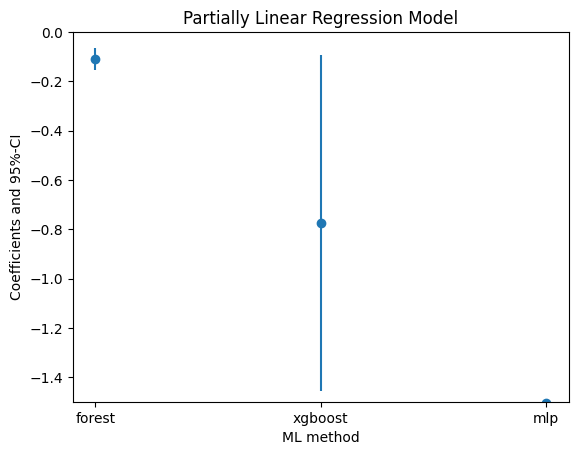

In [32]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([-1.5,0])

plt.title('Partially Linear Regression Model')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

# **Problem 3**
* Choose some pre-treatment covariates from the dataset that you think may explain the heterogeneity of the treatment effect. 
* Estimate the conditional average treatment effect of the treatment on the outcome given these covariates, using any method of your choice. 
* Describe your method and report your findings from this analysis.

1. ATE is of interest when we consider intervening all units. But personalized decision making depends on heterogeneity.

## data processing

In [6]:
# 按列统计缺失值数量
na_counts = data.isnull().sum()
print(na_counts[na_counts == 0].sort_index())

any_black                 0
automated_coding          0
baltimore                 0
census_tract              0
city                      0
dallas                    0
date_sent                 0
dc                        0
filled_september          0
five_star_property        0
guest_black               0
guest_female              0
guest_first_name          0
guest_gender              0
guest_id                  0
guest_last_name           0
guest_male                0
guest_race                0
guest_white               0
has_cleaning_fee          0
host_gender_F             0
host_gender_FF            0
host_gender_M             0
host_gender_MF            0
host_gender_MM            0
host_gender_same_sex      0
host_id                   0
host_race_asian           0
host_race_black           0
host_race_hisp            0
host_race_mult            0
host_race_white           0
host_response             0
listing_down              0
log_tract_listings        0
los_angeles         

In [7]:
# data各列的type
type_list=data.dtypes
print("value counts", type_list.value_counts())
lst =  type_list[type_list!="object"].index
len(lst)

value counts float64    46
int64      30
object     28
dtype: int64


76

In [8]:
data = data.fillna(data.mode().iloc[0])
# data[lst]每列的空值率
data[lst].isnull().mean().sort_values(ascending=False)#.head(10)

super_host                    1.0
number_of_messages            0.0
shared_bathroom               0.0
pricey                        0.0
old                           0.0
                             ... 
new_number_of_listings        0.0
host_id                       0.0
september_price               0.0
up_not_available_september    0.0
pr_filled                     0.0
Length: 76, dtype: float64

In [9]:
lst = lst.difference(['super_host', 'number_of_messages', 'apt_rating', 'cleaning_fee', 'september_price', 'up_not_available_september', 'available_september'])
lst = lst.difference(["yes","guest_black","guest_race_continuous"])

lst = lst.to_list()

In [10]:
data[data['guest_black'] == 1].count()

host_response         3082
response_date         3082
number_of_messages    3082
automated_coding      3082
latitude              3082
                      ... 
prop_black            3082
any_black             3082
past_guest_merge      3082
filled_september      3082
pr_filled             3082
Length: 104, dtype: int64

In [11]:
lst

['any_black',
 'asian_proportion',
 'asians',
 'automated_coding',
 'baltimore',
 'bathrooms',
 'bedrooms',
 'black_proportion',
 'blacks',
 'dallas',
 'date_sent_stata',
 'dc',
 'filled_september',
 'five_star_property',
 'guest_female',
 'guest_id',
 'guest_male',
 'guest_white',
 'has_cleaning_fee',
 'hispanic_proportion',
 'hispanics',
 'host_age_cat',
 'host_gender_F',
 'host_gender_FF',
 'host_gender_M',
 'host_gender_MF',
 'host_gender_MM',
 'host_gender_same_sex',
 'host_id',
 'host_race_asian',
 'host_race_black',
 'host_race_hisp',
 'host_race_mult',
 'host_race_white',
 'latitude',
 'listing_down',
 'log_price',
 'log_tract_listings',
 'longitude',
 'los_angeles',
 'middle',
 'multiple_listings',
 'new_number_of_listings',
 'number_guests',
 'number_of_listings',
 'number_of_reviews',
 'old',
 'population',
 'pr_filled',
 'price',
 'price_median',
 'pricey',
 'prop_black',
 'raw_black',
 'response_date_stata',
 'shared_bathroom',
 'shared_property',
 'sl',
 'strict_cancellat

In [12]:
len(lst)

66

In [13]:
# data用每列众数填充空值
data = data.fillna(data.mode().iloc[0])
data[lst]

,any_black,asian_proportion,asians,automated_coding,baltimore,bathrooms,bedrooms,black_proportion,blacks,dallas,...,shared_property,sl,strict_cancellation,ten_reviews,total_guests,tract_listings,verified_id,white_proportion,whites,young
0,0.0,0.145210,485.0,1.0,0,3.0,3.0,0.029940,100.0,0,...,1,0,0,0,11.0,16,1.0,0.535629,1789.0,0
1,0.0,0.057396,123.0,1.0,0,2.0,2.0,0.448437,961.0,0,...,1,0,0,1,167.0,19,1.0,0.395240,847.0,1
2,0.0,0.053684,306.0,0.0,0,1.0,1.0,0.046140,263.0,0,...,1,0,1,1,19.0,21,0.0,0.815439,4648.0,0
3,0.0,0.109172,244.0,0.0,0,8.0,8.0,0.043400,97.0,0,...,0,0,1,1,41.0,11,1.0,0.623266,1393.0,0
4,1.0,0.062069,207.0,0.0,0,3.0,3.0,0.023388,78.0,0,...,0,0,1,1,263.0,13,1.0,0.852474,2843.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6230,0.0,0.104435,398.0,0.0,0,2.0,2.0,0.017581,67.0,0,...,1,0,0,0,19.0,3,0.0,0.744686,2838.0,0
6231,0.0,0.066316,404.0,0.0,0,9.0,9.0,0.005909,36.0,0,...,0,0,1,0,1.0,10,0.0,0.883290,5381.0,0
6232,0.0,0.037379,178.0,0.0,0,6.0,6.0,0.006090,29.0,0,...,0,0,0,0,6.0,8,1.0,0.898152,4277.0,0
6233,1.0,0.139986,613.0,0.0,0,4.0,4.0,0.022836,100.0,0,...,0,0,1,0,10.0,1,0.0,0.721398,3159.0,0


In [14]:
data[lst].isnull().mean().sort_values(ascending=False)#.head(10)

any_black               0.0
price                   0.0
listing_down            0.0
log_price               0.0
log_tract_listings      0.0
                       ... 
host_gender_same_sex    0.0
host_id                 0.0
host_race_asian         0.0
host_race_black         0.0
young                   0.0
Length: 66, dtype: float64

## **load model packages**

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from econml.metalearners import TLearner, SLearner, XLearner
from econml.grf import CausalForest
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter
import matplotlib.pyplot as plt

## **All Covar**

In [16]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[lst].copy()  # 协变量

### **S-Learner**

In [17]:
def s_learner(X=X, Y=Y, T=T, type=None):
    # Step 1: 合并处理变量和协变量
    WX = pd.concat([T, X], axis=1)  # 合并处理变量 T 和协变量 X
    WX.columns = ['T'] + list(X.columns)  # 设置列名

    # Step 2: 训练回归森林模型
    rf = RandomForestRegressor(n_estimators=100, random_state=1234)
    rf.fit(WX, Y)  # 以 WX 为特征，以 Y 为目标变量训练模型

    # Step 3: 构造处理组和对照组特征矩阵
    W0X = WX.copy()
    W1X = WX.copy()
    W0X['T'] = 0  # 将处理变量设置为 0
    W1X['T'] = 1  # 将处理变量设置为 1

    # Step 4: 预测处理组和对照组的结果
    Y0_pred = rf.predict(W0X)  # 预测 W=0 时的因变量
    Y1_pred = rf.predict(W1X)  # 预测 W=1 时的因变量

    # Step 5: 计算 CATE
    cate_sl = Y1_pred - Y0_pred  # 处理效应

    print('CATE:', cate_sl.mean())

    # Step 6: 绘制 CATE 的直方图
    plt.hist(cate_sl, bins=30, edgecolor='k')
    plt.title('CATE Distribution (S-learner)')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.savefig(f'{type}_sl.png')
    plt.show()

CATE: -0.003116279069767442


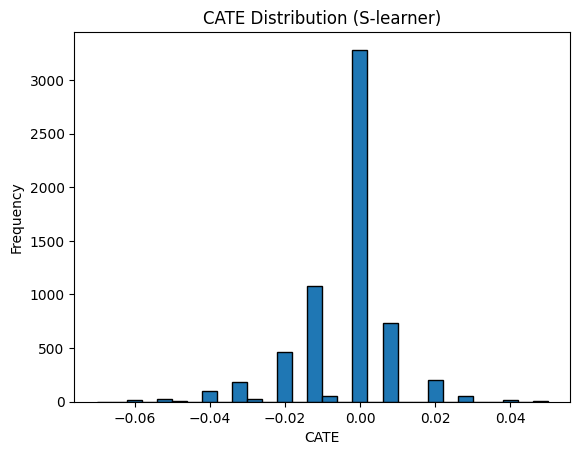

In [ ]:
s_learner(X=X, Y=Y, T=T, type='all')

### **T-learner**

In [18]:
def t_learner(X=X, Y=Y, T=T, type=None):
    # Step 1: 构建处理组和对照组数据
    X_treated = X[T == 1]  # 处理组 (W=1)
    Y_treated = Y[T == 1]  # 处理组的因变量
    X_control = X[T == 0]  # 对照组 (W=0)
    Y_control = Y[T == 0]  # 对照组的因变量

    # Step 2: 训练两个独立的回归森林模型
    rfm1 = RandomForestRegressor(n_estimators=100, random_state=42)
    rfm1.fit(X_treated, Y_treated)  # 用处理组数据训练

    rfm0 = RandomForestRegressor(n_estimators=100, random_state=42)
    rfm0.fit(X_control, Y_control)  # 用对照组数据训练

    # Step 3: 预测处理组和对照组的结果
    Y_pred_treated = rfm1.predict(X)  # 用处理组模型预测
    Y_pred_control = rfm0.predict(X)  # 用对照组模型预测

    # Step 4: 计算 CATE
    cate_tl = Y_pred_treated - Y_pred_control  # 条件平均处理效应

    print('CATE:', cate_tl.mean())
    # Step 5: 绘制 CATE 的直方图
    plt.hist(cate_tl, bins=30, edgecolor='k')
    plt.title('CATE Distribution (T-learner-raw)')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.savefig(f'{type}_tl-raw.png')
    plt.show()

CATE: -0.06499599037690457


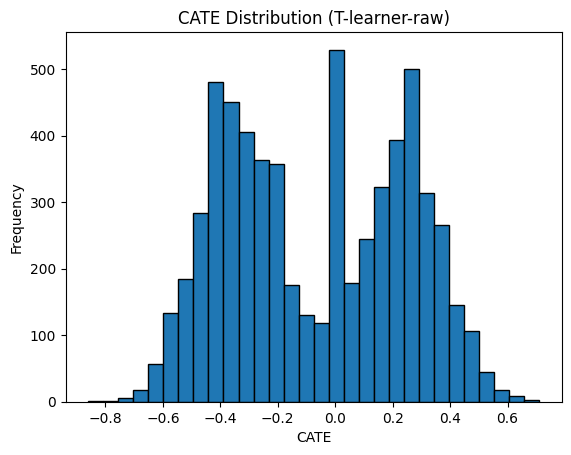

In [ ]:
t_learner(X=X, Y=Y, T=T, type='all')

### **Causal Tree**

In [19]:
def causal_tree(X=X, Y=Y, T=T, type=None):
    # 分开处理组和对照组
    X_treated = X[T == 1]
    Y_treated = Y[T == 1]
    X_control = X[T == 0]
    Y_control = Y[T == 0]

    # 训练两棵独立的决策树
    tree_treated = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)
    tree_treated.fit(X_treated, Y_treated)

    tree_control = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)
    tree_control.fit(X_control, Y_control)

    # 预测 CATE
    Y_treated_pred = tree_treated.predict(X)
    Y_control_pred = tree_control.predict(X)
    cate_causal_tree = Y_treated_pred - Y_control_pred

    print('CATE:', cate_causal_tree.mean())
    # 可视化 CATE 分布
    plt.hist(cate_causal_tree, bins=30, edgecolor='k')
    plt.title('CATE Distribution (Manual Causal Tree)')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.savefig(f'{type}_ct.png')
    plt.show()

CATE: -0.06765206364221481


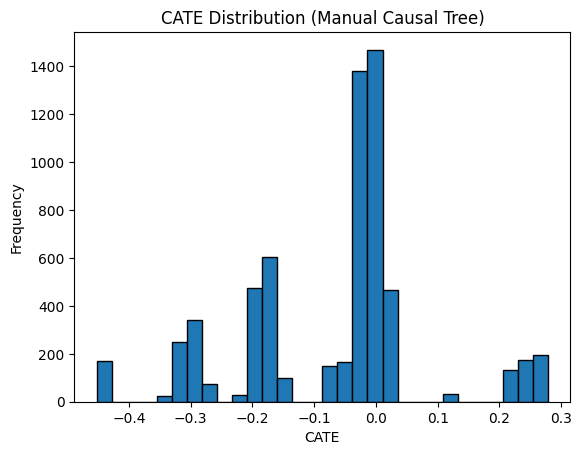

In [ ]:
causal_tree(X=X, Y=Y, T=T, type='all')

### **T-Learner with econml**

In [20]:
def t_learner_econml(X=X, Y=Y, T=T, type=None):
    # 分为训练集和测试集
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

    # 方法 1: T-Learner
    t_learner = TLearner(models=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))
    t_learner.fit(Y_train, T_train, X=X_train)

    # 计算 CATE
    cate_t_learner = t_learner.effect(X_test)

    # 输出结果
    t_learner_results = pd.DataFrame({'CATE_TLearner': cate_t_learner})
    # print(t_learner_results.head())
    print('CATE:', cate_t_learner.mean())

    # 绘制 T-Learner 的 CATE 分布直方图
    plt.figure(figsize=(8, 6))
    plt.hist(cate_t_learner, bins=30, edgecolor='k', alpha=0.7)
    plt.title('CATE Distribution - T-Learner')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f'{type}_tl.png')
    plt.show()

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08590490788773944


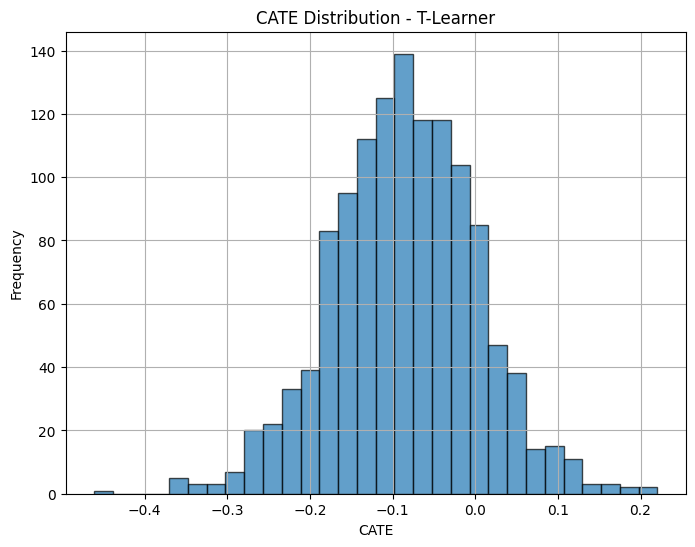

In [ ]:
t_learner_econml(X=X, Y=Y, T=T, type='all')

### **Causal Forest-grf**

In [21]:
def causal_forest(X=X, Y=Y, T=T, type=None):
    # 分为训练集和测试集
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=123)

    # 定义因果森林模型
    causal_forest = CausalForest(
        n_estimators=500,  # 树的数量
        max_depth=10,  # 最大树深度
        min_samples_leaf=10,  # 最小叶节点样本数
        random_state=123
    )

    # 训练因果森林模型
    causal_forest.fit(X_train, T_train, Y_train)

    # 预测 CATE
    cate_forest = causal_forest.predict(X_test)

    print('CATE:', cate_forest.mean())
    # 绘制 CATE 分布
    plt.figure(figsize=(8, 6))
    plt.hist(cate_forest, bins=30, edgecolor='k', alpha=0.7)
    plt.title('CATE Distribution - Causal Forest')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f'{type}_cf.png')
    plt.show()

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08470571371046719


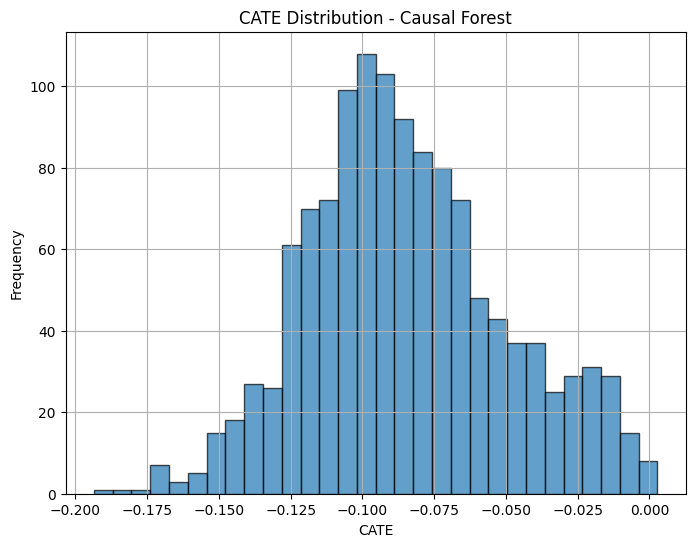

In [ ]:
causal_forest(X=X, Y=Y, T=T, type='all')

### **R-Learner**

In [22]:
### R-Learner
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

def r_learner(X=X, Y=Y, T=T, type=None):
    # 分为训练集和测试集
    X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=123)

    # Step 1: 回归模型预测倾向分数（Propensity Score）
    propensity_model = RandomForestRegressor()
    propensity_model.fit(X_train, T_train)
    propensity_scores = propensity_model.predict(X_test)

    # Step 2: 构建残差
    outcome_model = GradientBoostingRegressor()
    outcome_model.fit(X_train, Y_train)
    residuals = Y_test - outcome_model.predict(X_test)

    # 修复：对倾向分数进行剪枝
    clipped_propensity_scores = np.clip(propensity_scores, 0.01, 0.99)

    # Step 3: 用修正后的倾向分数计算残差比率
    r_learner_model = LinearRegression()
    r_learner_model.fit(X_test, residuals / clipped_propensity_scores)
    cate_r_learner = r_learner_model.predict(X_test)

    print('CATE:', cate_r_learner.mean())
    # 绘制 CATE 分布
    plt.figure(figsize=(8, 6))
    plt.hist(cate_r_learner, bins=30, edgecolor='k', alpha=0.7)
    plt.title('CATE Distribution - R-Learner')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f'{type}_rl.png')
    plt.show()

CATE: -1.3533034537370083


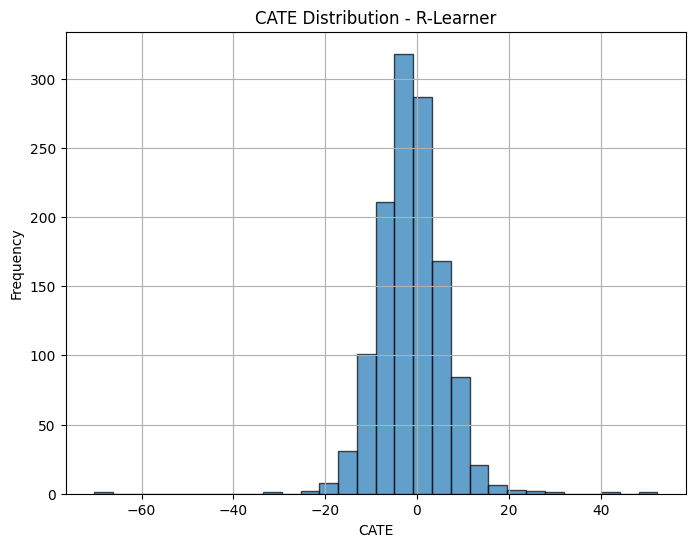

In [ ]:
r_learner(X=X, Y=Y, T=T, type='all')

## **Guest Info**

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08838160697414667


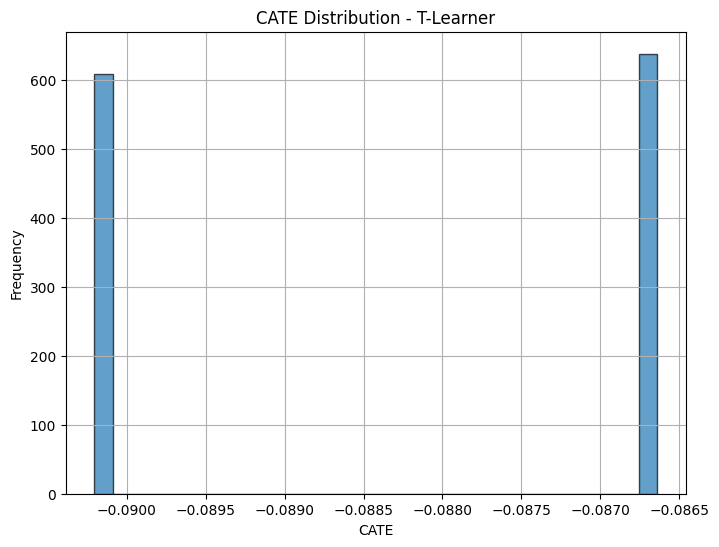

CATE: -0.03627331078991369


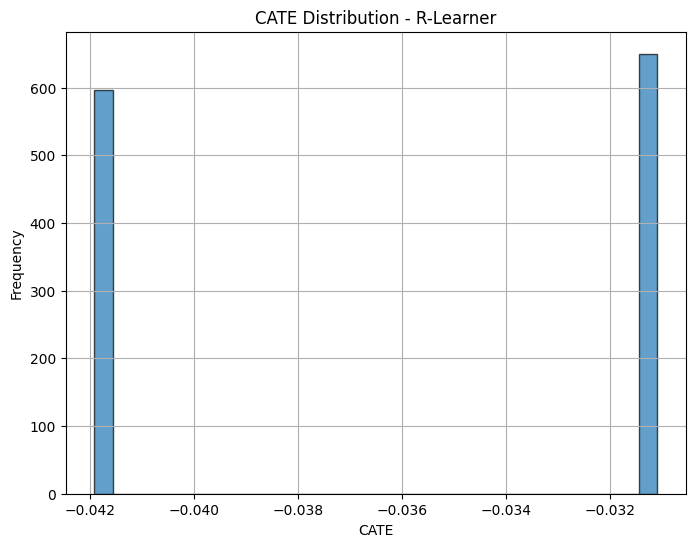

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08487016316237274


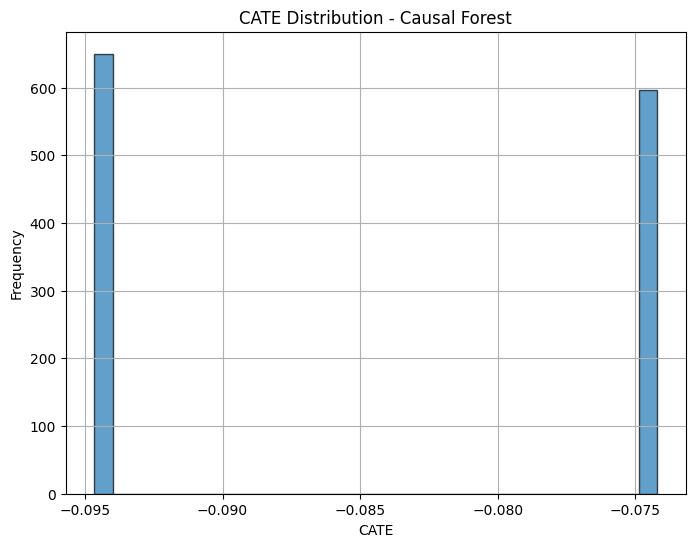

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['guest_female', 'guest_male']]
t_learner_econml(X=X, Y=Y, T=T, type='guest')
r_learner(X=X, Y=Y, T=T, type='guest')
causal_forest(X=X, Y=Y, T=T, type='guest')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


CATE: -0.08134328358208975


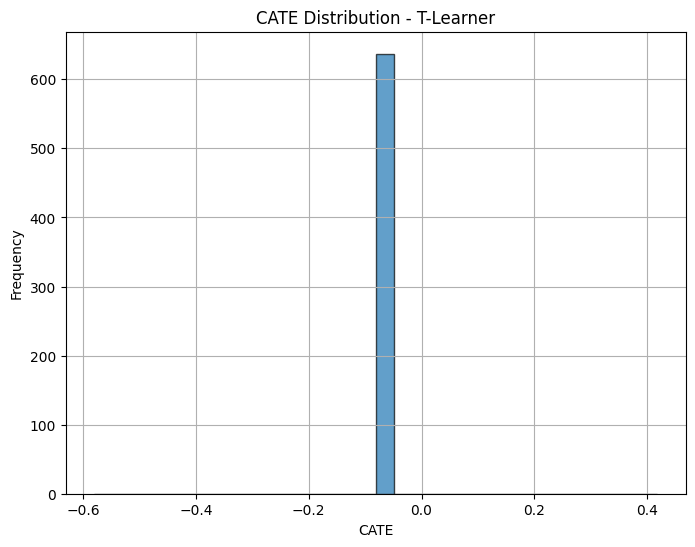

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CATE: -0.0030682751635525353


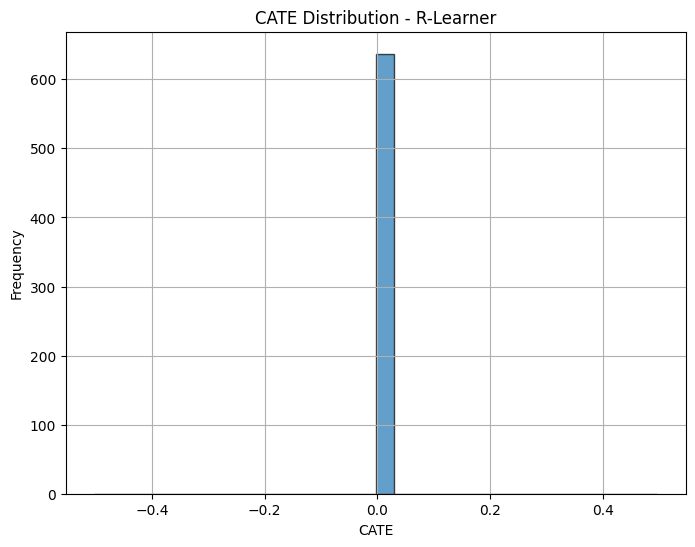

CATE: -0.0809856441117135


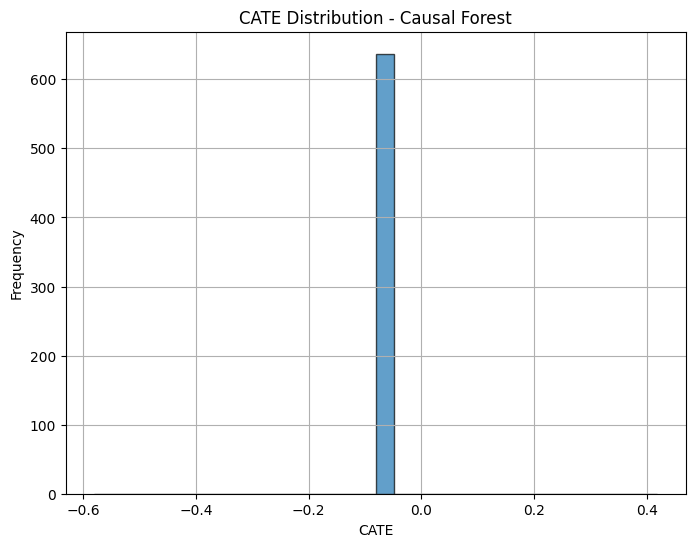

In [23]:
# 定义因变量、处理变量和协变量
Y = data[data['guest_female'] == 1]['yes'].astype(int)  # 因变量：是否接受预订
T = data[data['guest_female'] == 1][['guest_black']]  # 处理变量：租客是否为非裔
X = data[data['guest_female'] == 1][['guest_female']]#, 'guest_male'
t_learner_econml(X=X, Y=Y, T=T, type='guest_female')
r_learner(X=X, Y=Y, T=T, type='guest_female')
causal_forest(X=X, Y=Y, T=T, type='guest_female')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


CATE: -0.07700703662242125


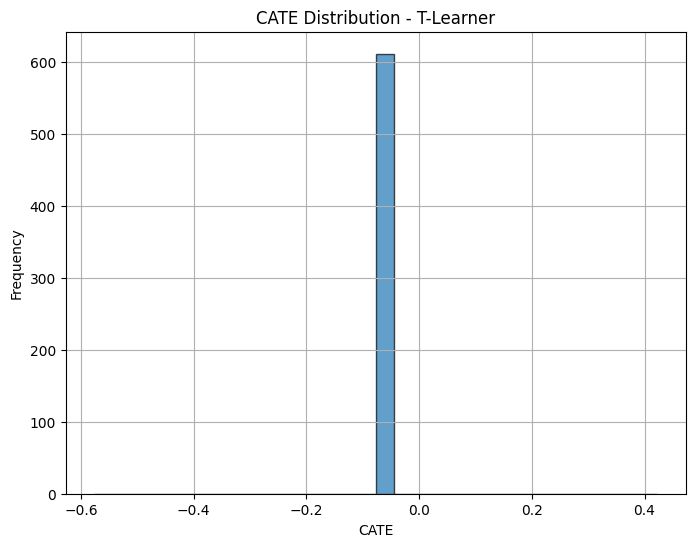

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CATE: -0.03330474215546128


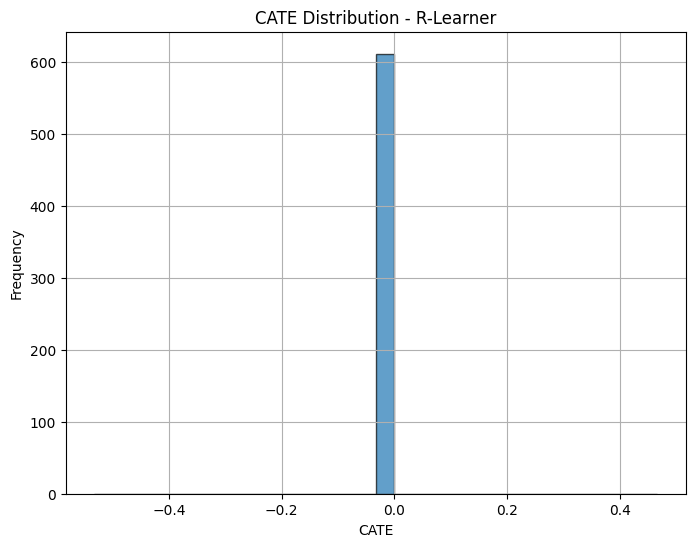

CATE: -0.07656876688986136


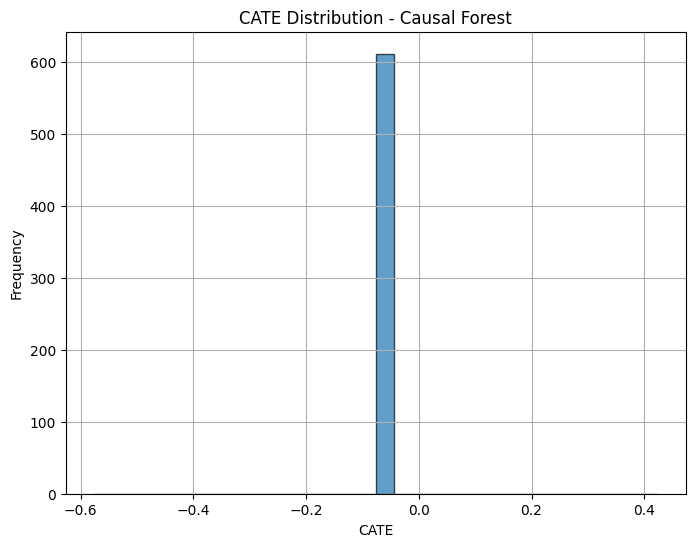

In [24]:
# 定义因变量、处理变量和协变量
Y = data[data['guest_male'] == 1]['yes'].astype(int)  # 因变量：是否接受预订
T = data[data['guest_male'] == 1][['guest_black']]  # 处理变量：租客是否为非裔
X = data[data['guest_male'] == 1][['guest_male']]#, 'guest_male'
t_learner_econml(X=X, Y=Y, T=T, type='guest_male')
r_learner(X=X, Y=Y, T=T, type='guest_male')
causal_forest(X=X, Y=Y, T=T, type='guest_male')

## **Host Info**

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.0924662041422354


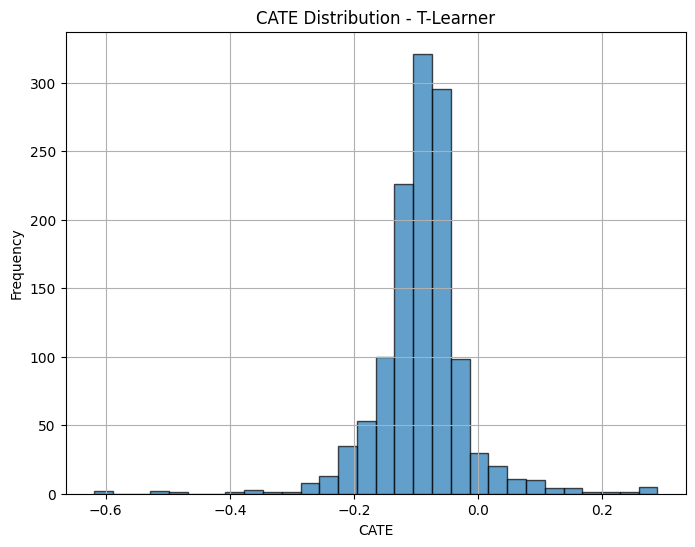

CATE: -0.1187578087521241


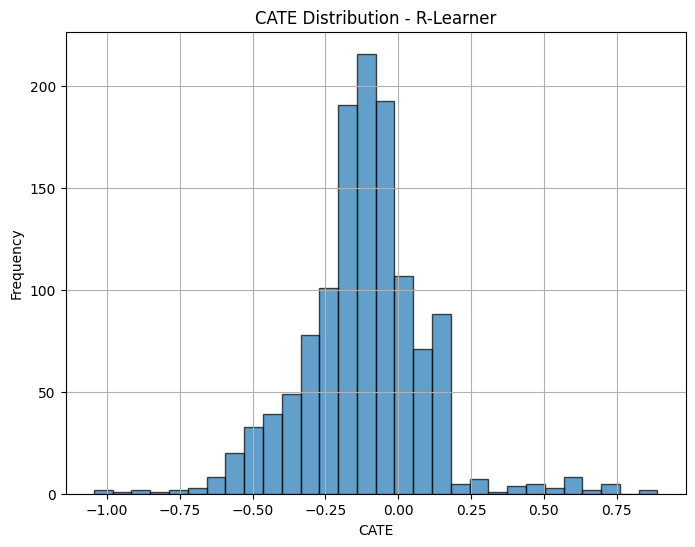

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.0871684936853058


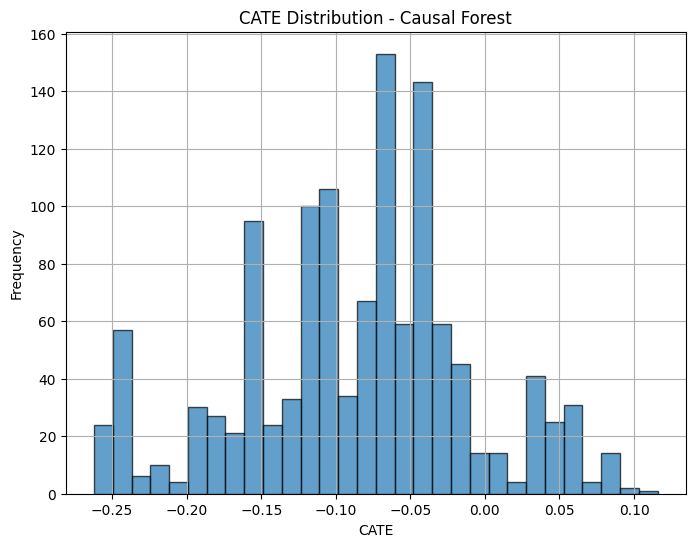

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['host_age_cat', 'host_gender_F', 'host_gender_FF', 'host_gender_M', 'host_gender_MF',  'host_gender_MM',
         'host_race_asian', 'host_race_black', 'host_race_hisp', 'host_race_mult', 'host_race_white',
         'young', "middle", "old",
         'ten_reviews','apt_rating']]
t_learner_econml(X=X, Y=Y, T=T, type='host_all')
r_learner(X=X, Y=Y, T=T, type='host_all')
causal_forest(X=X, Y=Y, T=T, type='host_all')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08873859909369441


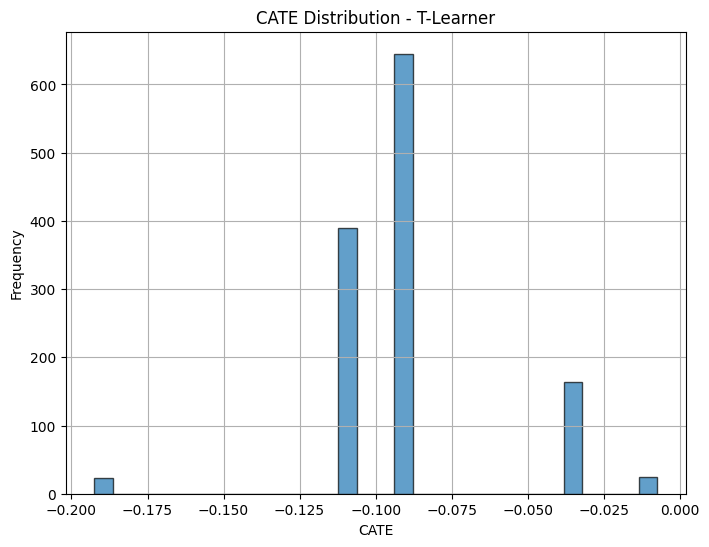

CATE: -0.03551724845782629


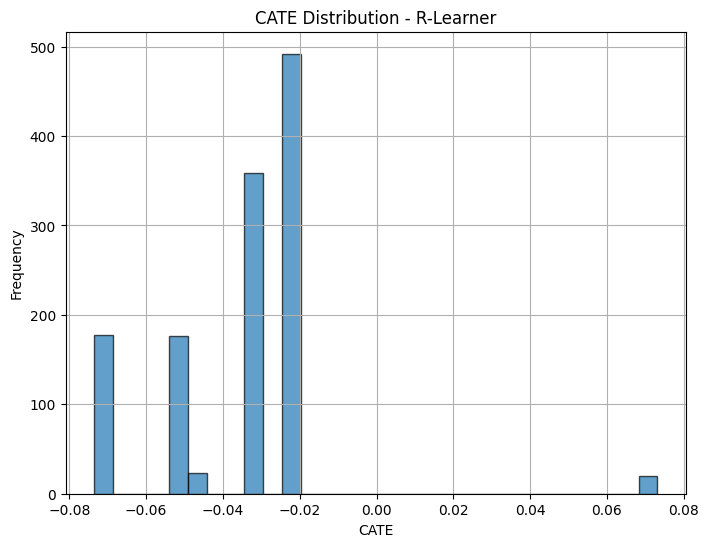

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08424552315356508


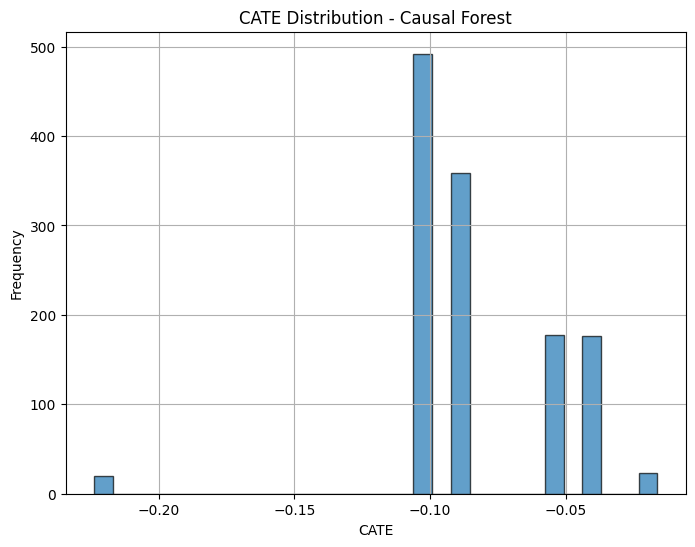

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['host_gender_F', 'host_gender_FF', 'host_gender_M', 'host_gender_MF',  'host_gender_MM']]
t_learner_econml(X=X, Y=Y, T=T, type='host_gender')
r_learner(X=X, Y=Y, T=T, type='host_gender')
causal_forest(X=X, Y=Y, T=T, type='host_gender')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.0891661509297895


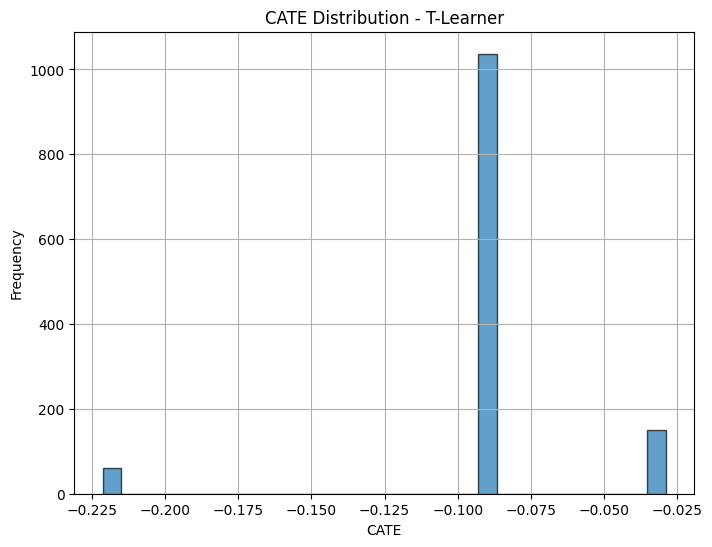

CATE: -0.03540500090981502


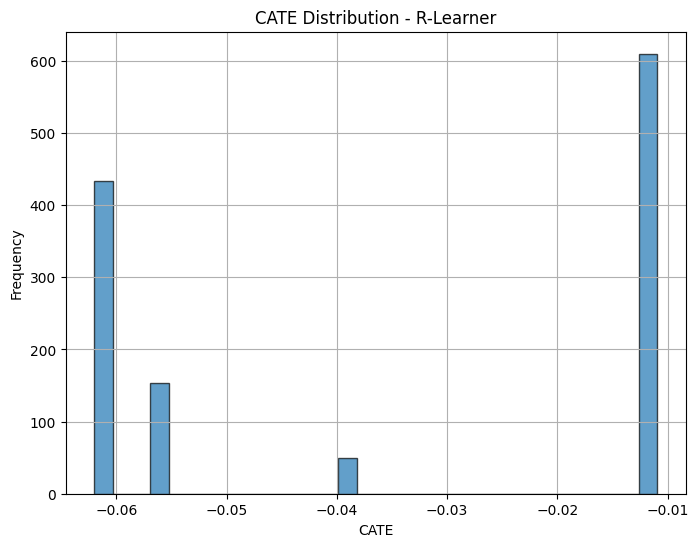

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.0835510255751088


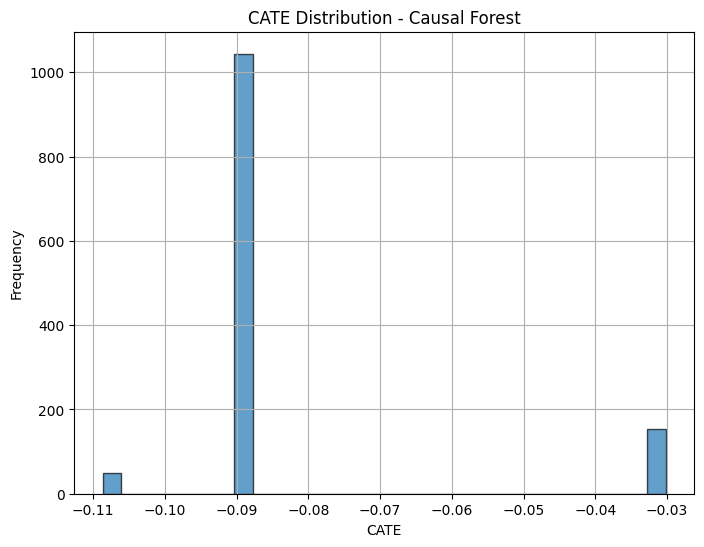

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['young', "middle", "old"]]# ', host_age_cat'
t_learner_econml(X=X, Y=Y, T=T, type='host_age')
r_learner(X=X, Y=Y, T=T, type='host_age')
causal_forest(X=X, Y=Y, T=T, type='host_age')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08820396954098274


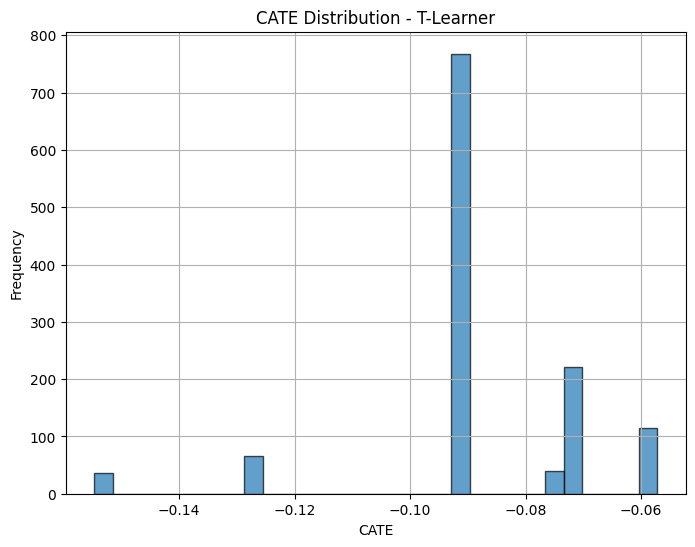

CATE: -0.030829139077958354


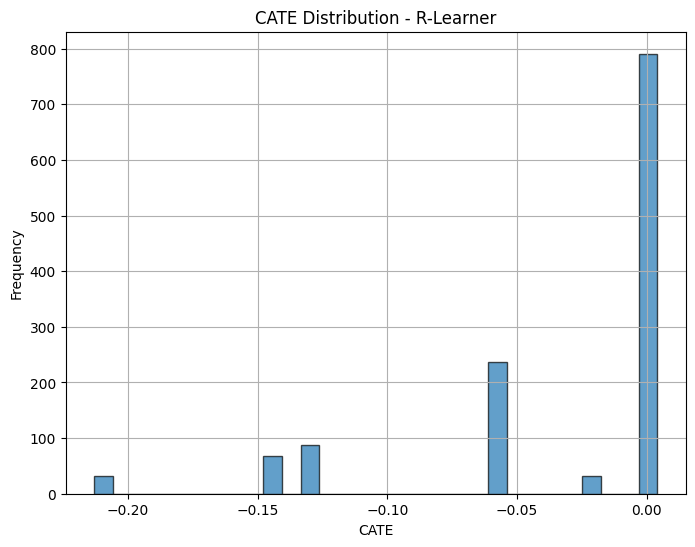

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08425379063830507


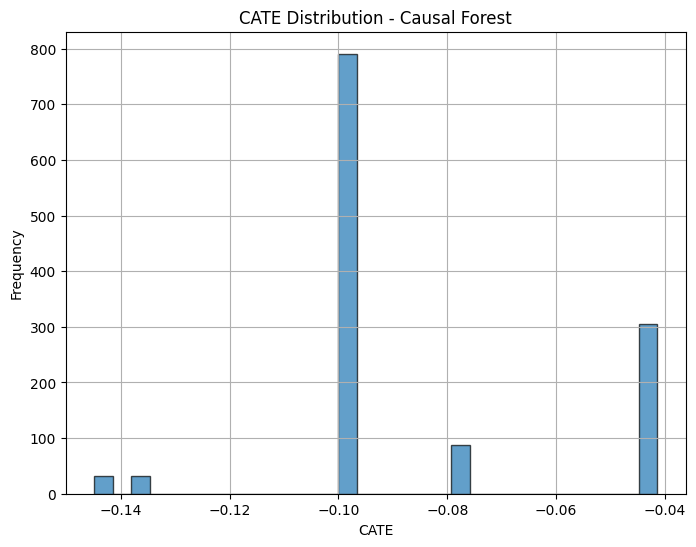

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['host_race_asian', 'host_race_black', 'host_race_hisp', 'host_race_mult', 'host_race_white']]
t_learner_econml(X=X, Y=Y, T=T, type='host_race')
r_learner(X=X, Y=Y, T=T, type='host_race')
causal_forest(X=X, Y=Y, T=T, type='host_race')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.09088558425256366


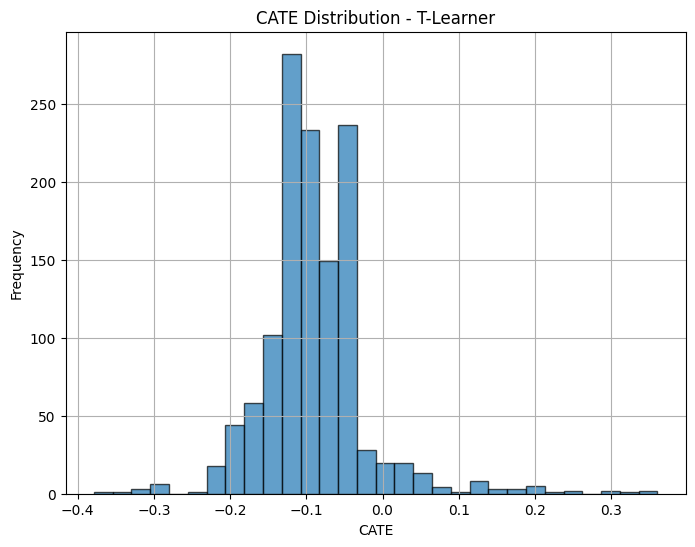

CATE: -0.09907461480768268


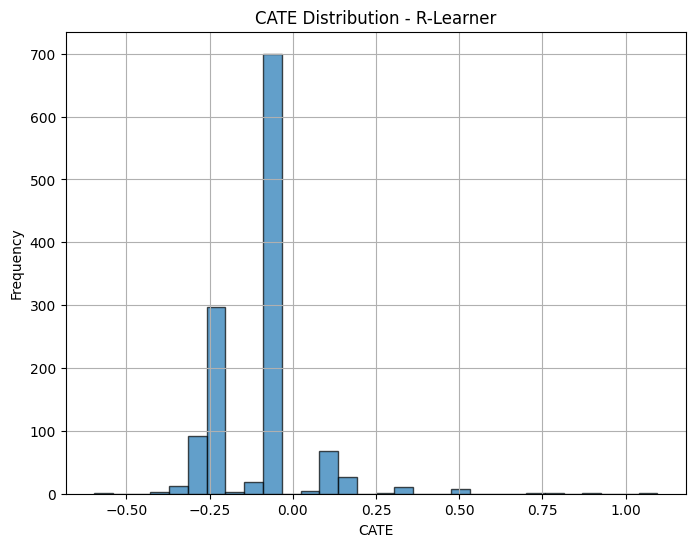

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08731442688432725


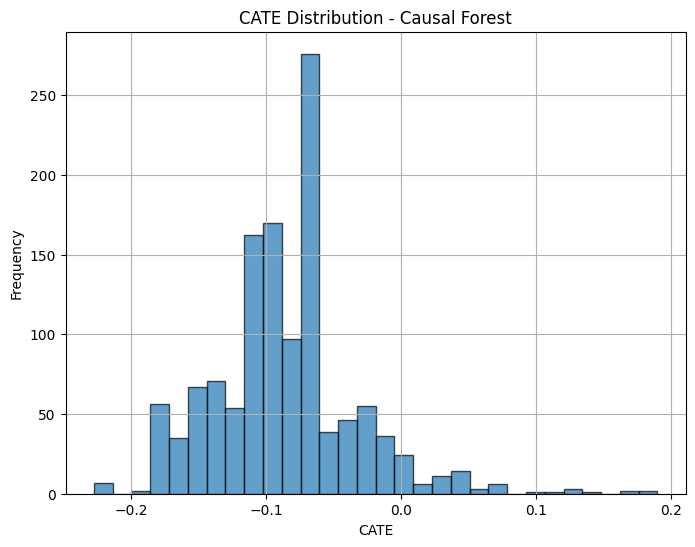

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['number_of_listings', 'number_of_reviews', 'ten_reviews','apt_rating']]
t_learner_econml(X=X, Y=Y, T=T, type='host_exp')
r_learner(X=X, Y=Y, T=T, type='host_exp')
causal_forest(X=X, Y=Y, T=T, type='host_exp')

## **House Info**

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.09156371003307769


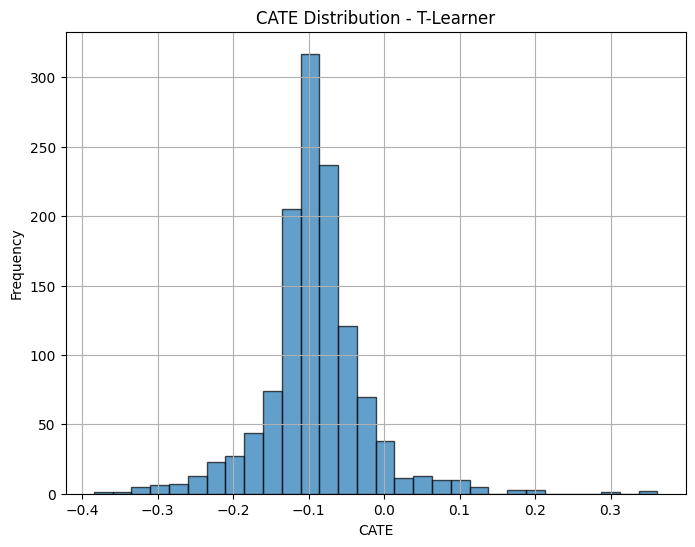

CATE: -0.27124318088200516


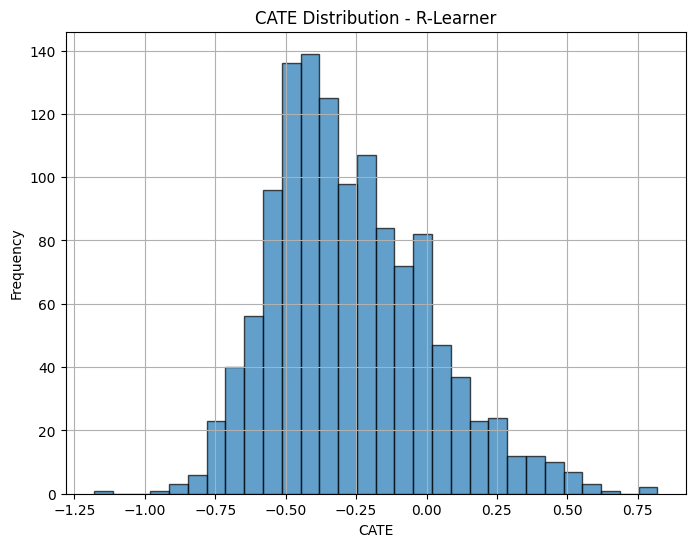

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08601590142914974


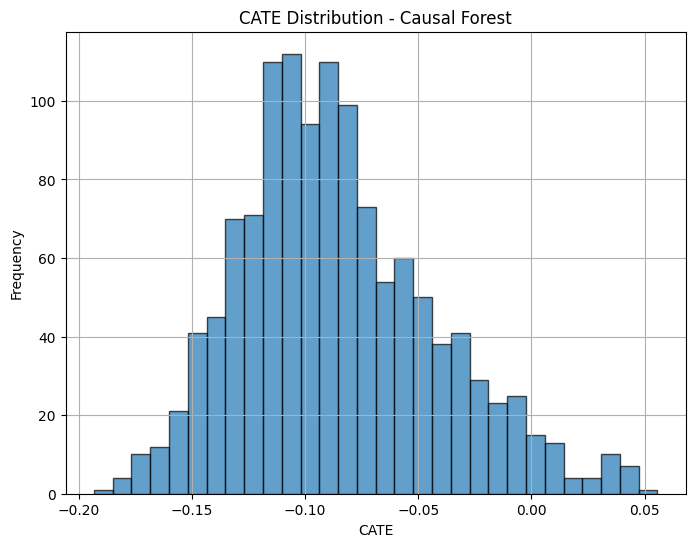

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['bathrooms', 'bedrooms','shared_bathroom', 'shared_property',
          'asian_proportion','black_proportion','hispanic_proportion','white_proportion',
          'baltimore','dallas','dc','los_angeles', 'sl',
          ]]
t_learner_econml(X=X, Y=Y, T=T, type='house_all')
r_learner(X=X, Y=Y, T=T, type='house_all')
causal_forest(X=X, Y=Y, T=T, type='house_all')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08769407710604465


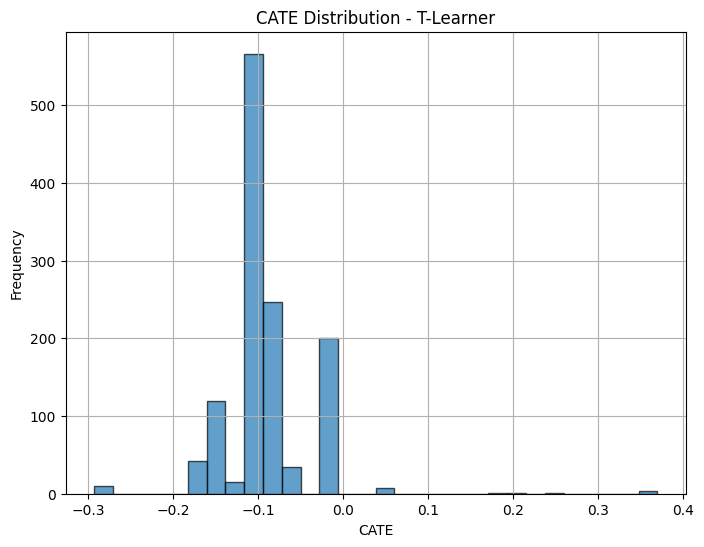

CATE: -0.03174179026016133


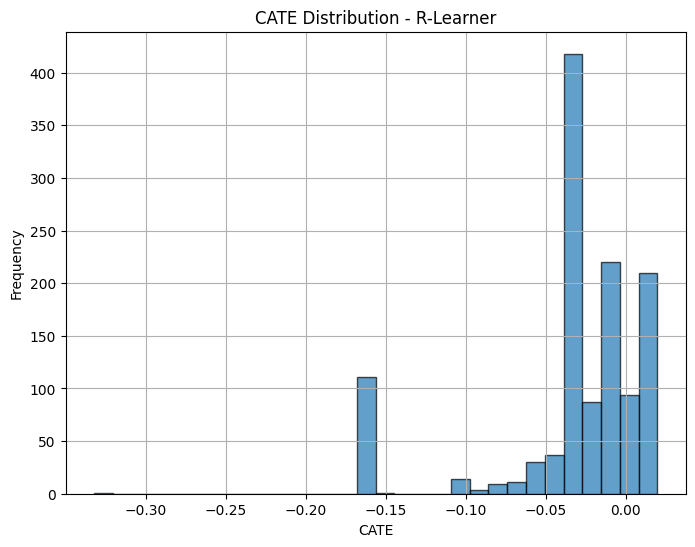

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08747727510640421


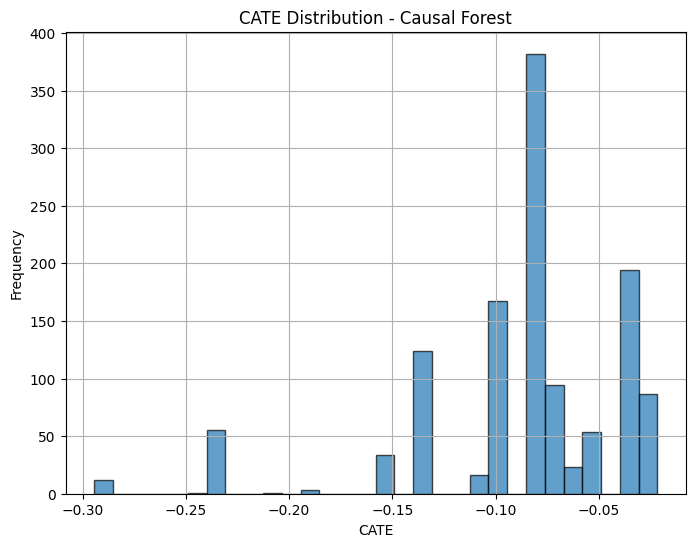

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[['bathrooms', 'bedrooms','shared_bathroom', 'shared_property',
        #   'asian_proportion','black_proportion','hispanic_proportion','white_proportion',
        #   'baltimore','dallas','dc','los_angeles', 'sl',
          ]]
t_learner_econml(X=X, Y=Y, T=T, type='house_rooms')
r_learner(X=X, Y=Y, T=T, type='house_rooms')
causal_forest(X=X, Y=Y, T=T, type='house_rooms')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08911038119685104


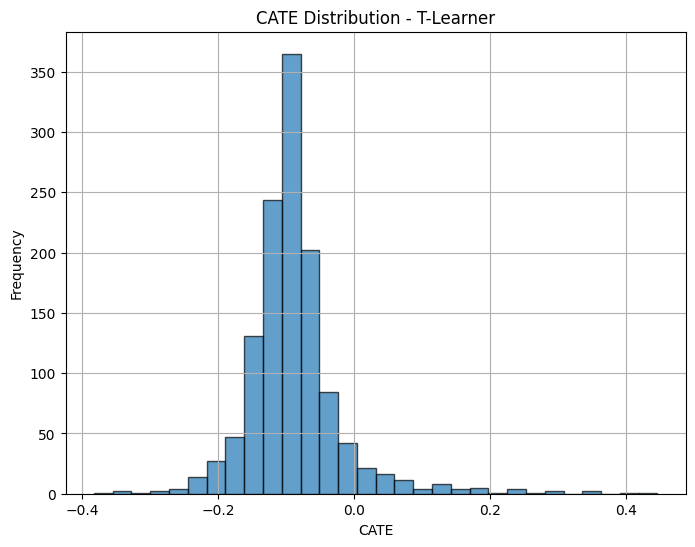

CATE: -0.10858529947467757


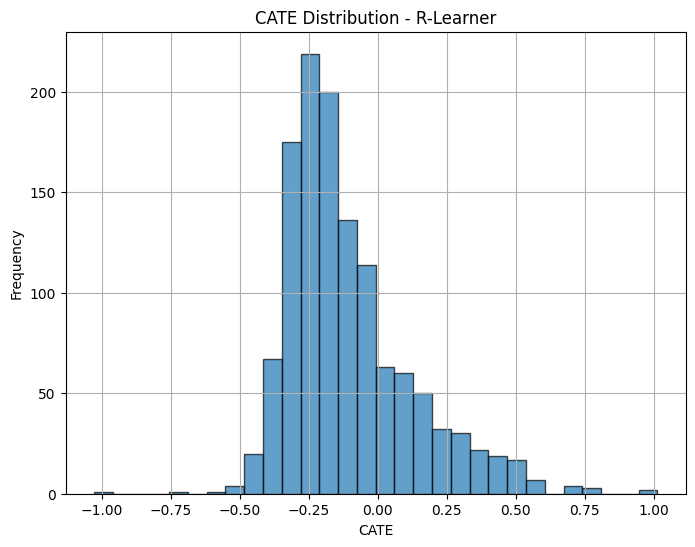

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08581302984978426


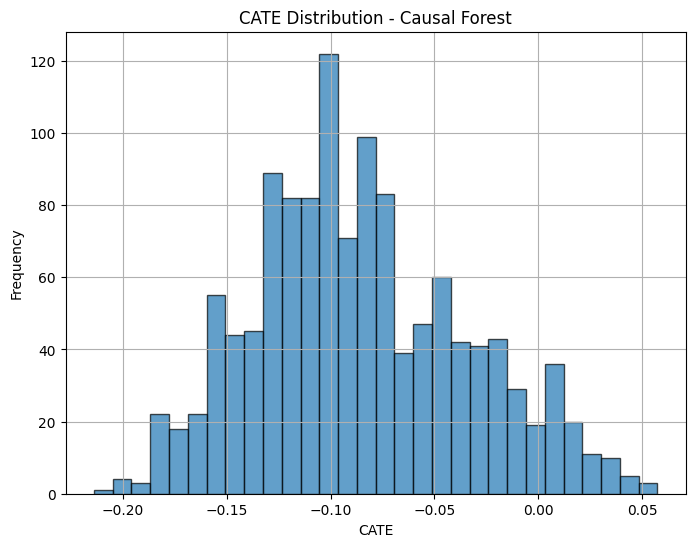

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[[
    # 'bathrooms', 'bedrooms','shared_bathroom', 'shared_property',
    'asian_proportion','black_proportion','hispanic_proportion','white_proportion',
    # 'baltimore','dallas','dc','los_angeles', 'sl',
        ]]
t_learner_econml(X=X, Y=Y, T=T, type='house_commu')
r_learner(X=X, Y=Y, T=T, type='house_commu')
causal_forest(X=X, Y=Y, T=T, type='house_commu')

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08894672444685853


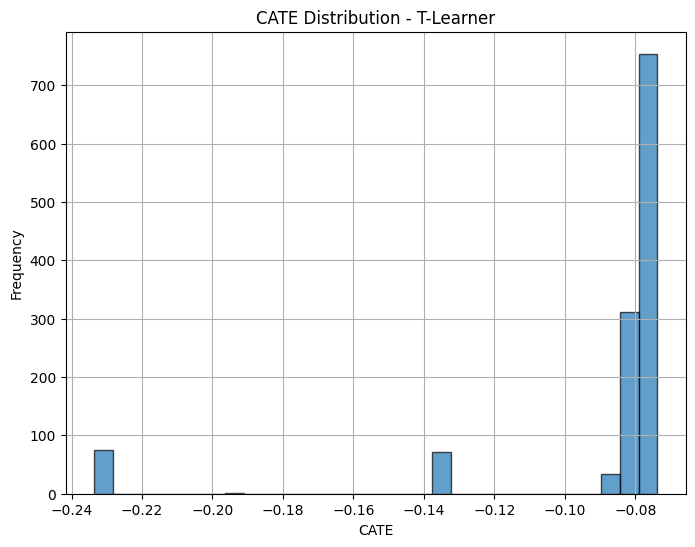

CATE: -0.03661134136587441


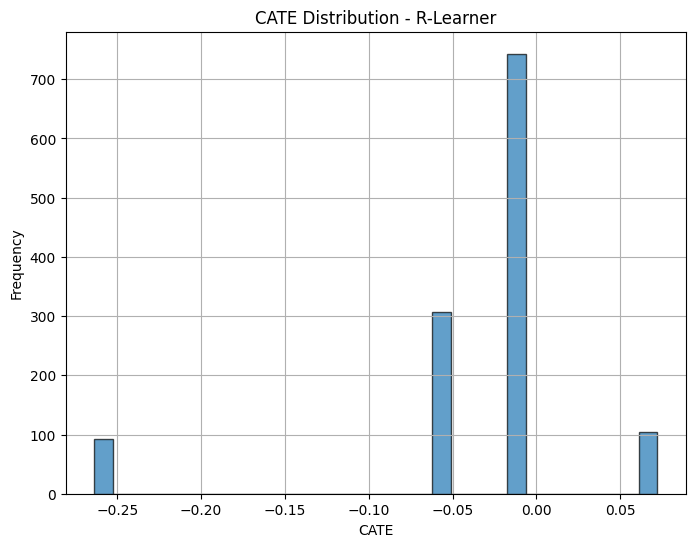

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


CATE: -0.08550482625219186


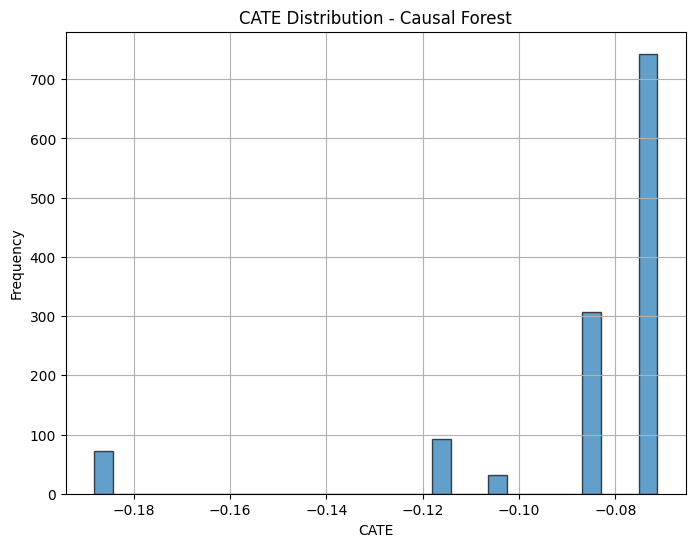

In [ ]:
# 定义因变量、处理变量和协变量
Y = data['yes'].astype(int)  # 因变量：是否接受预订
T = data['guest_black']  # 处理变量：租客是否为非裔
X = data[[
    # 'bathrooms', 'bedrooms','shared_bathroom', 'shared_property',
    # 'asian_proportion','black_proportion','hispanic_proportion','white_proportion',
    'baltimore','dallas','dc','los_angeles', 'sl',
        ]]
t_learner_econml(X=X, Y=Y, T=T, type='house_city')
r_learner(X=X, Y=Y, T=T, type='house_city')
causal_forest(X=X, Y=Y, T=T, type='house_city')